<a href="https://colab.research.google.com/github/tleitch/MoneyBallExamples/blob/main/MoneyBallStory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from sklearn import linear_model
from IPython.display import Image
from IPython.core.display import HTML 


sns.set(rc={'figure.figsize':(10,8)})
sns.set_style('white')

## Case study: Moneyball



_Moneyball: The Art of Winning an Unfair Game_ is a book by Michael Lewis about the Oakland Athletics (A's) baseball team and its general manager, the person tasked with building the team, Billy Beane. 

Traditionally, baseball teams use _scouts_ to help them decide what players to hire. These scouts evaluate players by observing them perform. Scouts tend to favor athletic players with observable physical abilities. For this reason, scouts tend to agree on who the best players are and, as a result, these players tend to be in high demand. This in turn drives up their salaries. 

From 1989 to 1991, the A's had one of the highest payrolls in baseball. They were able to buy the best players and, during that time, they were one of the best teams. However, in 1995 the A's team owner changed and the new management cut the budget drastically, leaving then general manager, Sandy Alderson, with one of the lowest payrolls in baseball. He could no longer afford the most sought-after players. Alderson began using a statistical approach to find inefficiencies in the market. Alderson was a mentor to Billy Beane, who succeeded him in 1998 and fully embraced data science, as opposed to scouts, as a method for finding low-cost players that data predicted would help the team win. Today, this strategy has been adapted by most baseball teams. As we will see, regression plays a large role in this approach.

As motivation for this chapter, we will pretend it is 2002 and try to build a baseball team with a limited budget, just like the A's had to do. To appreciate what you are up against, note that in 2002 the Yankees' payroll of  \$125,928,583 ** more than triple the Oakland A's ** \$39,679,746:





### Sabermetics

Statistics have been used in baseball since its beginnings. The dataset we will be using, included in the __Lahman__ library, goes back to the 19th century. For example, a summary statistics we will describe soon, the _batting average_, has been used for decades to summarize a batter's success. Other statistics^[http://mlb.mlb.com/stats/league_leaders.jsp] such as home runs (HR), runs batted in (RBI), and stolen bases (SB) are reported for each player in the game summaries included in the sports section of newspapers, with players rewarded for high numbers. Although summary statistics such as these were widely used in baseball, data analysis per se was not. These statistics were arbitrarily decided on without much thought as to whether they actually predicted anything or were related to helping a team win.

This changed with Bill James^[https://en.wikipedia.org/wiki/Bill_James]. In the late 1970s, this aspiring writer and baseball fan started publishing articles describing more in-depth analysis of baseball data. He named the approach of using data to predict what outcomes best predicted if a team would win _sabermetrics_^[https://en.wikipedia.org/wiki/Sabermetrics]. Until Billy Beane made sabermetrics the center of his baseball operation, Bill James' work was mostly ignored by the baseball world. Currently, sabermetrics popularity is no longer limited to just baseball; other sports have started to use this approach as well.


In this chapter, to simplify the exercise, we will focus on scoring runs and ignore the two other important aspects of the game: pitching and fielding. We will see how regression analysis can help develop strategies to build a competitive baseball team with a constrained budget. The approach can be divided into two separate data analyses. In the first, we determine which recorded player-specific statistics predict runs. In the second, we examine if players were undervalued based on what our first analysis predicts. 

### Baseball basics

To see how regression will help us find undervalued players, we actually don't need to understand all the details about the game of baseball, which has over 100 rules. Here, we distill the sport to the basic knowledge one needs to know how to effectively attack the data science problem. 

The goal of a baseball game is to score more runs (points) than the other team. Each team has 9 batters that have an opportunity to hit a ball with a bat in a predetermined order. After the 9th batter has had their turn, the first batter bats again, then the second, and so on. Each time a batter has an opportunity to bat, we call it a plate appearance (PA). At each PA, the other team's _pitcher_ throws the ball and the batter tries to hit it. The PA ends with an binary outcome: the batter either makes an _out_ (failure) and returns to the bench or the batter doesn't (success) and can run around the bases, and potentially score a run (reach all 4 bases). Each team gets nine tries, referred to as _innings_, to score runs and each inning ends after three outs (three failures).

Here is a video showing a success: [https://www.youtube.com/watch?v=HL-XjMCPfio](https://www.youtube.com/watch?v=HL-XjMCPfio). And here is one showing a failure: [https://www.youtube.com/watch?v=NeloljCx-1g](https://www.youtube.com/watch?v=NeloljCx-1g). In these videos, we see how luck is involved in the process. When at bat, the batter wants to hit the ball hard. If the batter hits it hard enough, it is a HR, the best possible outcome as the batter gets at least one automatic run. But sometimes, due to chance, the batter hits the ball very hard and a defender catches it, resulting in an out. In contrast, sometimes the batter hits the ball softly, but it lands just in the right place. The fact that there is chance involved hints at why probability models will be involved.

Now there are several ways to succeed. Understanding this distinction will be important for our analysis. When the batter hits the ball, the batter wants to pass as many _bases_ as possible. There are four bases with the fourth one called _home plate_. Home plate is where batters start by trying to hit, so the bases form a cycle.


(Courtesy of Cburnett^[https://en.wikipedia.org/wiki/User:Cburnett]. CC BY-SA 3.0 license^[https://creativecommons.org/licenses/by-sa/3.0/deed.en].)
<!--Source: [Wikipedia Commons](https://commons.wikimedia.org/wiki/File:Baseball_diamond_simplified.svg))-->

A batter who _goes around the bases_ and arrives home, scores a run. 


We are simplifying a bit, but there are five ways a batter can succeed, that is, not make an out: 

- Bases on balls (BB) - the pitcher fails to throw the ball through a predefined area considered to be hittable (the strikezone), so the batter is permitted to go to first base.
- Single - Batter hits the ball and gets to first base.
- Double (2B) - Batter hits the ball and gets to second base.
- Triple  (3B) - Batter hits the ball and gets to third base.
- Home Run (HR) - Batter hits the ball and goes all the way home and scores a run. 

Here  is an example of a HR:
  [https://www.youtube.com/watch?v=xYxSZJ9GZ-w](https://www.youtube.com/watch?v=xYxSZJ9GZ-w).
If a batter gets to a base, the batter still has a chance of getting home and scoring a run if the next batter hits successfully. While the batter is _on base_, the batter can also try to steal a base (SB). If a batter runs fast enough, the batter can try to go from one base to the next without the other team tagging the runner. [Here] is an example of a stolen base: [https://www.youtube.com/watch?v=JSE5kfxkzfk](https://www.youtube.com/watch?v=JSE5kfxkzfk).

All these events are kept track of during the season and are available to us through the __Lahman__ package. Now we will start discussing how data analysis can help us decide how to use these statistics to evaluate players.

### No awards for BB
 
Historically, the _batting average_ has been considered the most important offensive statistic. To define this average, we define a _hit_ (H) and an _at bat_ (AB). Singles, doubles, triples, and home runs are hits. The fifth way to be successful, BB, is not a hit. An AB is the number of times you either get a hit or make an out; BBs are excluded. The batting average is simply H/AB and is considered the main measure of a success rate. Today this success rate ranges from 20% to 38%. We refer to the batting average in thousands so, for example, if your success rate is 28%, we call it _batting 280_.



(Picture courtesy of Keith Allison^[https://www.flickr.com/people/27003603@N00]. CC BY-SA 2.0 license^[https://creativecommons.org/licenses/by-sa/2.0].)

One of Bill James' first important insights is that the batting average ignores BB, but a BB is a success.  He proposed we use the _on base percentage_ (OBP) instead of batting average. He defined OBP as (H+BB)/(AB+BB) which is simply the proportion of plate appearances that don't result in an out, a very intuitive measure. He noted that a player that gets many more BB than the average player might not be recognized if the batter does not excel in batting average. But is this player not helping produce runs? No award is given to the player with the most BB. However, bad habits are hard to break and baseball did not immediately adopt OBP as an important statistic. In contrast, total stolen bases were considered important and an award^[http://www.baseball-almanac.com/awards/lou_brock_award.shtml] given to the player with the most. But players with high totals of SB also made more outs as they did not always succeed. Does a player with high SB total help produce runs? Can we use data science to determine if it's better to pay for players with high BB or SB? 

### Base on balls or stolen bases?

One of the challenges in this analysis is that it is not obvious how to determine if a player produces runs because so much depends on his teammates. We do keep track of the number of runs scored by a player. However, remember that if a player X bats right before someone who hits many HRs, batter X will score many runs. But these runs don't necessarily happen if we hire player X but not his HR hitting teammate.  However, we can examine team-level statistics. How do teams with many SB compare to teams with few? How about BB? We have data! Let's examine some. 

But first, let's hear from Billy Bean (via Brad Pitt):
[https://www.youtube.com/watch?v=PlKDQqKh03Y]

Let's start with an obvious one: HRs. Do teams that hit more home runs score more runs? We examine data from 1961 to 2001. The visualization of choice when exploring the relationship between two variables, such as HRs and wins, is a scatterplot.

## Load data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/tleitch/MoneyBallExamples/main/Moneyball/data/baseball.csv?token=ABYEFIUHUWBHANCWMGMJOM3BRQWXM')
df.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


#Data Wrangling to get Scatterplot
Let us add a new column; RD, which shows the difference between RS(Runs Scored), and RA(Runs Allowed). 

df['RD'] = df['RS'] - df['RA']


In [3]:
df['RD'] = df['RS'] - df['RA']


Let’s also make sure we only have pre-’Moneyball’ data, this can be done by only including data from before the 2002 regular season. df = df[df.Year < 2002]

In [4]:
df = df[df.Year < 2002]

And here we add our dependent variable, whether or not the team made the playoffs. We put a 1 in for made pplayoffs, and 0 for didn't. This should be familiar dependent variable to you from logistic regression

In [5]:
mbplayoffs = df[df.Playoffs == 1]

In [6]:
mbnoplayoffs = df[df.Playoffs == 0]

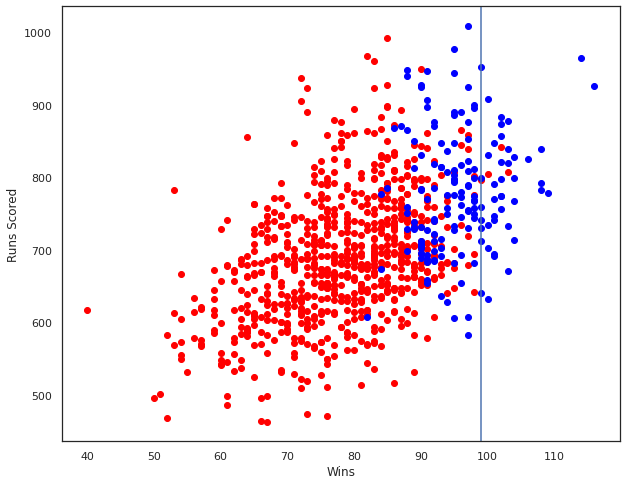

In [7]:
# Plotting scatterplot
plt.figure(figsize=(10,8))
plt.scatter(x=mbnoplayoffs.W,y = mbnoplayoffs.RS,c="red")
plt.scatter(x=mbplayoffs.W,y = mbplayoffs.RS,c="blue")
plt.xlabel("Wins")
plt.ylabel("Runs Scored")
plt.axvline(x = 99)

In 2011, the film “Moneyball” was released. The film — adapted from the book by Micheal Lewis, is based on a true story, and follows Oakland A’s general manager Billy Beane, who, after losing his star players, must find a way to reach the playoffs whilst faced with a tight budget. Enter Paul DePodesta, an Ivy League graduate, who, using Sabermetrics, is able to identify the ‘bargain’ players in order to build the team that go on the A’s notorious 20 game win streak and see them finishing 1st in the regular season, throwing the art of sabermetrics into the limelight.


#Linear Regression
Linear Regression is one of the simplest forms of supervised machine learning which models a target prediction value (usually denoted by y) based on independent variables (usually denoted by X).


![](https://raw.githubusercontent.com/tleitch/MoneyBallExamples/f8f82e9894aef7f5fdbf2459f40e989610408af1/Moneyball/img/moneyballReg.jpeg?token=ABYEFIS7D6TZGSTOGQACDGTBRRYZS)







*   Y — The dependent variable (Target prediction value)
*   X — Independent variable(s)
*   β — Regression coefficients: These refer to the relationship between the x variable and the dependent variable y.
*   ε — Error term: used to denote the a residual variable produced by a statistical or mathematical model, which is created when the model does not fully represent the actual relationship between the independent variables and the dependent variables. As a result of this incomplete relationship, the error term is the amount at which the equation may differ during empirical analysis.

The job of a linear regression model is essentially to find a linear relationship between the input (X) and output (y).


The main attributes that we need to be concerned with are:

*   RS — Runs Scored
*   RA — Runs Allowed
*   W — Wins
*   OBP — On Base Percentage
*   SLG — Slugging Percentage
*   BA — Batting Average
*   Playoffs — Whether a team made it to playoffs or not
*   OOBP — Opponent’s On Base Percentage
*   OSLG — Opponents Slugging Percentage



Some of these are fairly self explanatory, however there are a few attributes that require some explaining:

OBP — On Base Percentage: This is a statistic measuring how frequently a batter reaches base, it does not take into account how far the batter runs i.e. third base.

SLG — Slugging Percentage: A measure of the batting ‘Productivity’, in simple terms, it measures how far a batter makes it when they hit the ball.

BA — Batting Average: Defined by the number of hits divided by at bats, measures how likely a batter is to hit a ball when pitched. Again, does not take into account how far the batter runs.

Now, all three of these statistics are extremely important in this analysis. Pre-’Moneyball’, scouts mainly used Batting Average as a gauge of a good batter, and often a players BA would have a huge impact on their value/salary. However, DePodesta saw this as a mistake, claiming that scouts overvalued BA as a statistic, and massively undervalued OBP and SLG as a measure of a good batter. Billy Beane and the A’s were then able to obtain players with high OBP and SLG at bargain prices, because the scouts overlooked these attributes.



#EDA

According to DePodesta, the A’s needed 99 wins in the regular season in order to make playoffs. We can create a plot to visualise this using Seaborn, which is a data visualisation library based on matplotlib.

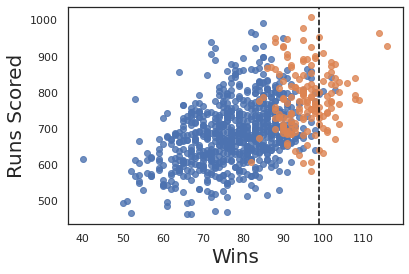

In [8]:
sns.regplot(x = mbnoplayoffs["W"], y = mbnoplayoffs["RS"], fit_reg = False)
sns.regplot(x = mbplayoffs["W"], y = mbplayoffs["RS"], fit_reg = False)
plt.xlabel("Wins", fontsize = 20)
plt.ylabel("Runs Scored", fontsize = 20)
plt.axvline(99, 0, 1, color = "Black", ls = '--')
plt.show()

As we can see, DePodestas theory seems accurate, as there has only ever been 3 instances where a team has not made playoffs with ≥ 99 wins (seen in the blue dots past the dashed black 99 wins ‘threshold’ line).
DePodesta also calculated that in order to win 99 games and make it to the playoffs, the A’s would have to score 814 runs, whilst allowing just 645, a run differential of 169. We can use many different methods to visualise the relationship between Run Difference and Wins, and we will use two of them.


Firstly, a simple scatterplot:

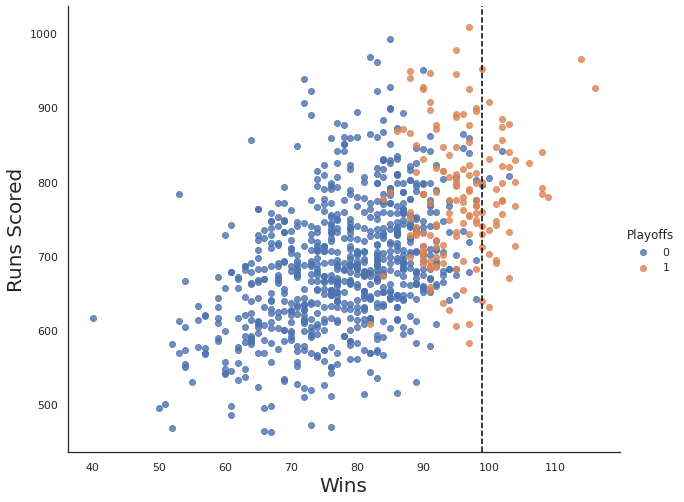

In [9]:
sns.lmplot(x = "W", y = "RS", fit_reg = False, hue = "Playoffs", data=df,height=7, aspect=1.25)
plt.xlabel("Wins", fontsize = 20)
plt.ylabel("Runs Scored", fontsize = 20)
plt.axvline(99, 0, 1, color = "Black", ls = '--')
plt.show()

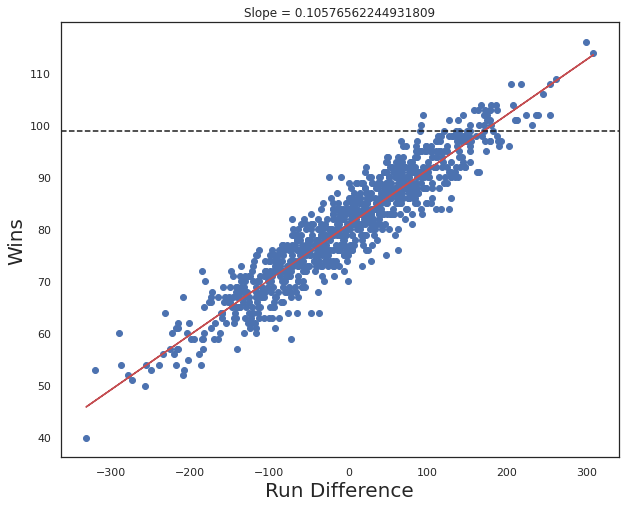

In [10]:
x = np.array(df.RD)
y = np.array(df.W)
slope, intercept = np.polyfit(x, y, 1)
abline_values = [slope * i + intercept for i in x]
plt.figure(figsize=(10,8))
plt.scatter(x, y)
plt.plot(x, abline_values, 'r')
plt.title("Slope = %s" % (slope), fontsize = 12)
plt.xlabel("Run Difference", fontsize =20)
plt.ylabel("Wins", fontsize = 20)
plt.axhline(99, 0, 1, color = "k", ls = '--')
plt.show()

Secondly: We can use the Seaborn pairplot:

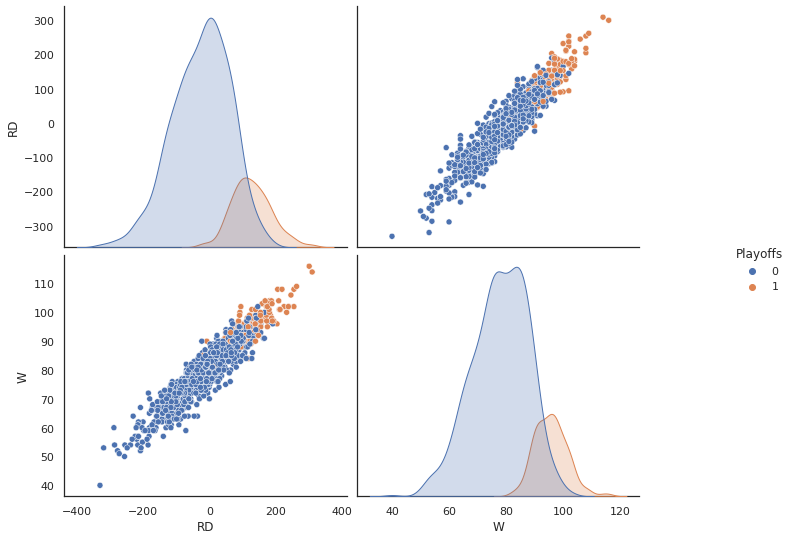

In [11]:
corrcheck = df[['RD', 'W', 'Playoffs']].copy()
g = sns.pairplot(corrcheck, hue = 'Playoffs',vars=["RD", "W"])
g.fig.set_size_inches(12,8)

We can already see that there is a clear linear relationship between the two, however, we can further verify this by using Pandas .corr(), which computes the pairwise correlation between columns.

In [12]:
corrcheck.corr(method='pearson')

,RD,W,Playoffs
RD,1.000000,0.938515,0.566274
W,0.938515,1.000000,0.588978
Playoffs,0.566274,0.588978,1.000000


We can see a correlation of 0.938515 between Wins and Run Difference, indicating an extremely strong relationship.
Now we know that Run Difference correlates so strongly with Wins, what attributes correlate strongly with Run Difference? As we previously mentioned, Scouts at the time relied heavily on Batting Average, and, according to DePodesta, undervalued On Base Percentage and Slugging Percentage. Again we can use the .corr() Pandas function, to compute the pairwise correlation between columns.

In [13]:
podesta = df[['OBP','SLG','BA','RS']]
podesta.corr(method='pearson')

,OBP,SLG,BA,RS
OBP,1.000000,0.806154,0.854055,0.904909
SLG,0.806154,1.000000,0.814068,0.926384
BA,0.854055,0.814068,1.000000,0.831625
RS,0.904909,0.926384,0.831625,1.000000


In [14]:
moneyball = df.dropna()

In [15]:
moneyball.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
331,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141
332,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86
338,CLE,AL,2001,897,821,91,0.350,0.458,0.278,1,6.0,4.0,162,0.341,0.417,76
342,HOU,NL,2001,847,769,93,0.347,0.451,0.271,1,4.0,4.0,162,0.325,0.437,78
349,NYY,AL,2001,804,713,95,0.334,0.435,0.267,1,3.0,2.0,161,0.318,0.398,91


Note the right hand column here, which shows RS’s relationship with OBP, SLG, and BA. We can see that Batting Average is actually the least correlated attribute in respect to Runs Scored, with a correlation of 0.83. Slugging Percentage and On Base Percentage are actually correlated more highly, with 0.93 and 0.90, respectively. This confirms DePodestas idea of the undervalue placed on SLG and OBP and the relative overvaluing of BA.
We can actually apply a bit of machine learning to further verify these claims. Firstly, by using univariate selection, to select those features that have the strongest relationship with the output variable(RD in this case). The scikit-learn library provides the SelectKBest class that allows us to pick a specific number of features. We will use the chi-squared statistical test for non-negative features to select the best features from our dataset. Firstly we need to use moneyball = df.dropna() to remove any null values from our dataset that would interfere with machine learning methods.
Then:

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#we use RD as the target column
X = moneyball.iloc[:,6:9] 
y = moneyball.iloc[:,-1] 
#apply SelectKBest class to get best features
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
print(featureScores.nlargest(3,'Score')) 

  Feature     Score
1     SLG  0.008951
0     OBP  0.006262
2      BA  0.004577


#Model Building
Scikit-learn provides the functionality for us to build our linear regression models. First of all, we build a model for Runs Scored, predicted using On Base Percentage and Slugging Percentage.

In [17]:
x = df[['OBP','SLG']].values
y = df[['RS']].values
Runs = linear_model.LinearRegression()
Runs.fit(x,y)

print(Runs.intercept_)
print(Runs.coef_)

[-804.62706106]
[[2737.76802227 1584.90860546]]


In [18]:
x = moneyball[['OOBP','OSLG']].values
y = moneyball[['RA']].values
RunsAllowed = linear_model.LinearRegression()
RunsAllowed.fit(x,y)

print(RunsAllowed.intercept_)
print(RunsAllowed.coef_)

[-775.16234861]
[[3225.00378812 1106.50390975]]


We can then say that our Runs Scored model takes the form:
**RS = -804.627 + (2737.768×(OBP)) + (1584.909×(SLG))**
Next, we do the same but for modelling Runs Allowed, using Opponents On Base Percentage and Opponents Slugging Percentage.


In [19]:
x = moneyball[['RD']].values
y = moneyball[['W']].values
Wins = linear_model.LinearRegression()
Wins.fit(x,y)

print(Wins.intercept_)
print(Wins.coef_)

[84.09190385]
[[0.08469339]]


We can say that our Wins model takes the form:
W = 84.092 + (0.085 ×(RD))
Now all we have left to do is get OBP, SLG, OOBP, OSLG, and simply plug them into the models!
**We know which players were transferred in and out after the 2001 season, so we can take 2001 player statistics to build the A’s new 2002 team.**
The A’s 2002 team pre-season statistics taken from 2001:
OBP: 0.339
SLG: 0.430
OOBP: 0.307
OSLG: 0.373
Now lets create our predictions:

In [20]:
# Prediction for runs scored.
Runs.predict([[0.339,0.430]])

array([[804.98699884]])

In [21]:
# Predictions for runs allowed.
RunsAllowed.predict([[0.307,0.373]])

array([[627.63977268]])

Meaning we get a RD of 177 (805–628), which we can then plug into our Wins model.

In [22]:
Wins.predict([[177]])

array([[99.08263325]])

So, in the end, **our model predicted 805 Runs Scored, 628 Runs Allowed, and 99 games won, meaning that our model predicted that the A’s would make the playoffs given their team statistics, which they did!**
